**Importing Necessary Libraries**

In [1]:
%pip install torchsummary

import time

import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
import torchvision.models as models
import torchvision.models._utils as _utils
from torch.autograd import Variable
from collections import OrderedDict

Note: you may need to restart the kernel to use updated packages.


**Mobilenet**

In [2]:
# conv_bn为网络的第一个卷积块，步长为2
def conv_bn(inp, oup, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


# conv_dw为深度可分离卷积
def conv_dw(inp, oup, stride=1):
    return nn.Sequential(
        # 3x3卷积提取特征，步长为2
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU6(inplace=True),

        # 1x1卷积，步长为1
        nn.Conv2d(inp, oup, 1, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True),
    )


class MobileNet(nn.Module):
    def __init__(self, n_channels):
        super(MobileNet, self).__init__()
        self.layer1 = nn.Sequential(
            # 第一个卷积块，步长为2，压缩一次
            conv_bn(n_channels, 32, 1),  # 416,416,3 -> 208,208,32

            # 第一个深度可分离卷积，步长为1
            conv_dw(32, 64, 1),  # 208,208,32 -> 208,208,64

            # 两个深度可分离卷积块
            conv_dw(64, 128, 2),  # 208,208,64 -> 104,104,128
            conv_dw(128, 128, 1),

            # 104,104,128 -> 52,52,256
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
        )
        # 52,52,256 -> 26,26,512
        self.layer2 = nn.Sequential(
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
        )
        # 26,26,512 -> 13,13,1024
        self.layer3 = nn.Sequential(
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
        )
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg(x)

        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MobileNet(n_channels=3)
    model.to(device)
    summary(model, input_size=(3,256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]           2,048
       BatchNorm2d-8         [-1, 64, 256, 256]             128
             ReLU6-9         [-1, 64, 256, 256]               0
           Conv2d-10         [-1, 64, 128, 128]             576
      BatchNorm2d-11         [-1, 64, 128, 128]             128
            ReLU6-12         [-1, 64, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]           8,192
      BatchNorm2d-14        [-1, 128, 1

**Unet with Mobilenet**

In [3]:

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


def conv2d(filter_in, filter_out, kernel_size, groups=1, stride=1):
    pad = (kernel_size - 1) // 2 if kernel_size else 0
    return nn.Sequential(OrderedDict([
        ("conv", nn.Conv2d(filter_in, filter_out, kernel_size=kernel_size, stride=stride, padding=pad, groups=groups, bias=False)),
        ("bn", nn.BatchNorm2d(filter_out)),
        ("relu", nn.ReLU6(inplace=True)),
    ]))


class mobilenet(nn.Module):
    def __init__(self, n_channels):
        super(mobilenet, self).__init__()
        self.model = MobileNet(n_channels)

    def forward(self, x):
        out3 = self.model.layer1(x)
        out4 = self.model.layer2(out3)
        out5 = self.model.layer3(out4)

        return out3, out4, out5


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, num_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.num_classes = num_classes

        # ---------------------------------------------------#
        #   64,64,256；32,32,512；16,16,1024
        # ---------------------------------------------------#
        self.backbone = mobilenet(n_channels)

        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = DoubleConv(1024, 256)

        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = DoubleConv(512, 128)

        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        #nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv4 = DoubleConv(128, 64)

        self.oup = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        #  backbone
        x2, x1, x0 = self.backbone(x)
        # print(f"x2.shape: {x2.shape}, x1: {x1.shape}, x0: {x0.shape} ")

        P5 = self.up1(x0)
        P5 = self.conv1(P5)           # P5: 26x26x512
        # print(P5.shape)
        P4 = x1                       # P4: 26x26x512
        P4 = torch.cat([P4, P5], axis=1)   # P4(堆叠后): 26x26x1024
        # print(f"cat 后是： {P4.shape}")

        P4 = self.up2(P4)             # 52x52x1024
        P4 = self.conv2(P4)           # 52x52x256
        P3 = x2                       # x2 = 52x52x256
        P3 = torch.cat([P4, P3], axis=1)  # 52x52x512

        P3 = self.up3(P3)
        P3 = self.conv3(P3)

        P3 = self.up4(P3)
        P3 = self.conv4(P3)

        out = self.oup(P3)
        # print(f"out.shape is {out.shape}")

        return out
    
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(n_channels=3,num_classes=1)
    model.to(device)
    summary(model, input_size=(3,256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 64, 256, 256]           2,048
       BatchNorm2d-8         [-1, 64, 256, 256]             128
             ReLU6-9         [-1, 64, 256, 256]               0
           Conv2d-10         [-1, 64, 128, 128]             576
      BatchNorm2d-11         [-1, 64, 128, 128]             128
            ReLU6-12         [-1, 64, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]           8,192
      BatchNorm2d-14        [-1, 128, 1

**Data Loading and Training and Testing Part**

Importing Libraries

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.models as model
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision
from torch.utils.data import DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from numpy import random
# !pip install focal_loss_torch
# from focal_loss.focal_loss import FocalLoss
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

# 
from torchsummary import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_23/1083700853.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [5]:
!mkdir output

In [6]:
class SlumDataset(Dataset):
  def __init__(self,image_dir,mask_dir,transform = None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.mask = os.listdir(mask_dir)

  def __len__(self):
    return len(self.mask)

  def __getitem__(self,index):
    img_path = os.path.join(self.image_dir,self.images[index])
    mask_path = os.path.join(self.mask_dir,self.mask[index])

    # img_path = self.image_dir[index]
    # mask_path = self.mask_dir[index]

    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path), dtype = np.float32)
    # mask = np.array(Image.open(mask_path))

    mask = (mask//246.0)

    if self.transform != None:
      augmentations = self.transform(image = image,mask = mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image,mask

# def distributeData(train_image,train_mask,train_val):
#     images = os.listdir(train_image)
#     masks = os.listdir(train_mask)

#     for i in range(0,len(images)):
#       images[i] = os.path.join(train_image,images[i])

#     for i in range(0,len(masks)):
#       masks[i] = os.path.join(train_mask,masks[i])


#     train_img, valid_img = images[:int(train_val*len(images))], images[int(train_val*len(images)):]
#     train_mask,valid_mask = masks[:int(train_val*len(masks))],masks[int(train_val*len(masks)):]

#     return train_img,train_mask,valid_img,valid_mask

def save_checkpoint(state,filename = "my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state,filename)

def load_checkpoint(checkpoint,model,optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

def check_accuracy(loader,model,accuracy_vals,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_score = 0
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))

      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      dice_score += (2*(preds*y).sum())/((preds+y).sum() + 1e-8)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # index = accu.cpu().data.numpy().argmax()
  print(accu.item())
  accuracy_vals.append(accu.item())

  print(f"Dice score: {dice_score/len(loader)}")
  model.train()

def save_predictions_as_imgs(loader,model,folder,device = "cuda"):
  model.eval()
  for idx, (x,y) in enumerate(loader):
    x = x.to(device = device)

    with torch.no_grad():
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()

    torchvision.utils.save_image(preds,f"{folder}/pred_{idx}.jpg")
    torchvision.utils.save_image(y.unsqueeze(1),f"{folder}/{idx}.jpg")

  model.train()


def my_plot(epochs, loss):
  plt.xlabel("losses")
  plt.ylabel("Num of epochs")
  plt.plot(epochs, loss)

In [7]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    train_val,
    num_workers = 2,
    pin_memory = True,
):

  # train_img,train_mask,val_img,val_mask = distributeData(train_dir,train_maskdir,train_val)

  train_ds = SlumDataset(
      image_dir = train_dir,
      mask_dir = train_mask_dir,
      transform = train_transform
  )

  train_loader = DataLoader(
      train_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = True,
  )

  val_ds = SlumDataset(
      image_dir = val_dir,
      mask_dir = val_mask_dir,
      transform = val_transform
  )

  val_loader = DataLoader(
      val_ds,
      batch_size = batch_size,
      num_workers = num_workers,
      pin_memory = pin_memory,
      shuffle = False,
  )

  return train_loader, val_loader


In [8]:
# Hyperparameters
# LEARNING_RATE = [1e-4,1e-3,1e-2]
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 15
NUM_WORKERS = 2
train_val = 0.8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
train_valid = 0.8
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = '/kaggle/input/slum-dataset/train_img/train_img'
TRAIN_MASK_DIR = '/kaggle/input/slum-dataset/train_mask-20230822T130205Z-001/train_mask'
val_dir = '/kaggle/input/slum-dataset/val_img-20230822T130211Z-001/val_img'
val_mask_dir = '/kaggle/input/slum-dataset/val_mask-20230822T130216Z-001/val_mask'
saved_folder = '/kaggle/working/'

In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def train_fn(epoch,num_epochs,loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train):
  total_loss = 0.0
  total_iou = 0.0
  total_precision = 0.0
  total_recall = 0.0
  total_f1 = 0.0
  total_accuracy = 0.0

  length = len(loader);
  loop = tqdm(loader)

  for batch_idx, (data,targets) in enumerate(loop):
    data = data.to(device = device)
    targets = targets.float().unsqueeze(1).to(device = device)
    targ = targets

    # forward
    with torch.cuda.amp.autocast():
      predictions = torch.sigmoid(model(data))

      loss = loss_fn(predictions,targets)
      total_loss += loss.item()

      # convert model outputs to binary mask using sigmoid and threshold
      predicted_masks = predictions
      predicted_masks = (predicted_masks > 0.5).float()

      preds = predicted_masks.cpu().numpy()
      yy = targ.cpu().numpy()

      # Calculate the intersection and union of the binary masks
      intersection = np.sum(preds * yy)
      union = np.sum(np.logical_or(preds, yy))
      iou = intersection / union

      precision = precision_score(yy.flatten(), preds.flatten())
      recall = recall_score(yy.flatten(), preds.flatten())
      f1 = f1_score(yy.flatten(), preds.flatten())
      accuracy = np.mean(yy.flatten() == preds.flatten())

      total_iou += iou
      total_precision += precision
      total_recall += recall
      total_f1 += f1
      total_accuracy += accuracy

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss = loss.item())

  average_loss = total_loss / length
  average_iou = total_iou / length
  average_precision = total_precision / length
  average_recall = total_recall / length
  average_f1 = total_f1 / length
  average_accuracy = accuracy /length

  # Append metrics and losses to lists for plotting
  loss_train.append(average_loss)
  iou_train.append(average_iou)
  precision_train.append(average_precision)
  recall_train.append(average_recall)
  f1_train.append(average_f1)
  accuracy_train.append(average_accuracy)

  print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {average_loss:.4f}, "
          f"IoU: {average_iou:.4f}, "
          f"Precision: {average_precision:.4f}, "
          f"Recall: {average_recall:.4f}, "
          f"F1: {average_f1:.4f},"
          f"Accuracy: {average_accuracy:4f}"
  )

In [10]:
def dice_coefficient(predicted_mask, ground_truth_mask):
  intersection = np.sum(predicted_mask * ground_truth_mask)
  predicted_area = np.sum(predicted_mask)
  ground_truth_area = np.sum(ground_truth_mask)

  dice = (2.0 * intersection) / (predicted_area + ground_truth_area)
  return dice

def check_accuracy(loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = "cuda"):
  num_correct = 0
  num_pixels = 0
  dice_s = []
  precision_s = []
  f1_s = []
  iou_s = []
  recall_s = []
  accuracy_s = []
  model.eval()

  with torch.no_grad():
    for x,y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      pred = torch.sigmoid(model(x))

      pred = (pred > 0.5).float()
      num_correct += (pred == y).sum()
      num_pixels += torch.numel(pred)
      preds = pred.cpu().numpy()
      yy = y.cpu().numpy()

      for pred_mask, gt_mask in zip(preds, yy):
        # Flatten the binary masks for precision calculation
        pred_mask_flat = pred_mask.flatten()
        gt_mask_flat = gt_mask.flatten()

        # Calculate recall score for the current mask
        recall = recall_score(gt_mask_flat, pred_mask_flat)
        recall_s.append(recall)

        # Calculate precision for the current mask
        precision = precision_score(gt_mask_flat, pred_mask_flat)
        precision_s.append(precision)

        # Calculate F1 score for the current mask
        f1 = f1_score(gt_mask_flat, pred_mask_flat)
        f1_s.append(f1)

        # Calculate the intersection and union of the binary masks
        intersection = np.sum(pred_mask * gt_mask)
        union = np.sum(np.logical_or(pred_mask, gt_mask))

        # Calculate IoU for the current mask
        iou = intersection / union
        iou_s.append(iou)

        # Calculate Accuarcy for the current mask
        accuracy = np.mean(gt_mask_flat == pred_mask_flat)
        accuracy_s.append(accuracy)

        dice_score = dice_coefficient(pred_mask, gt_mask)
        dice_s.append(dice_score)

  accu = (num_correct/num_pixels)*100
  print(f"Got {num_correct}/{num_pixels} with accuracy {accu}")

  # Calculate the average precision over the validation dataset
  average_precision = np.mean(precision_s)
  print(f"Average Precision: {average_precision:.4f}")

  #Calculate the average accuracy over the validation dataset
  accuracy_vals.append(np.mean(accuracy_s))
  print(f'Accuracy: {np.mean(accuracy_s)}')

  # Calculate the average Dice score over the validation dataset
  average_dice = np.mean(dice_s)
  print(f"Average Dice Score: {average_dice:.4f}")

  # Calculate the average F1 score over the validation dataset
  average_f1 = np.mean(f1_s)
  print(f"Average F1 Score: {average_f1:.4f}")

  # Calculate the average IoU score over the validation dataset
  average_iou = np.mean(iou_s)
  print(f"Average IoU Score: {average_iou:.4f}")

  # Calculate average metrics for the epoch
  iou_scores.append(average_iou)
  precision_scores.append(average_precision)
  recall_scores.append(np.mean(recall_s))
  f1_val.append(average_f1)
  dice_scores.append(average_dice)

  model.train()

In [11]:
def func(NUM_EPOCHS,loss_train,iou_train,precision_train,recall_train,f1_train,iou_scores,precision_scores,recall_scores, f1_val,dice_scores, accuracy_vals):
  epochs = np.arange(1, NUM_EPOCHS + 1)
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, loss_train, label='Train_Loss')
  plt.plot(epochs, iou_train, label='Train_IoU')
  plt.plot(epochs, precision_train, label='Train_Precision')
  plt.plot(epochs, recall_train, label='Train_Recall')
  plt.plot(epochs, f1_train, label='Train_F1')
  # plt.plot(epochs, accuracy_train, label='Train_Accuracy')

  plt.xlabel('Train_Epoch')
  plt.ylabel('Score / Loss')
  plt.title('Training Metrics and Losses Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

  # PLot validation metrics
  plt.figure(figsize=(12, 8))

  plt.plot(epochs, iou_scores, label='validation_IoU')
  plt.plot(epochs, precision_scores, label='validation_Precision')
  plt.plot(epochs, recall_scores, label='validation_Recall')
  plt.plot(epochs, f1_val, label='validation_F1')
  plt.plot(epochs, dice_scores, label='validation_Dice')
  plt.plot(epochs,accuracy_vals,label = "validation_Accuracy")

  plt.xlabel('validation_Epoch')
  plt.ylabel('Score')
  plt.title('Validation Metrics Over Epochs')
  plt.legend()
  plt.grid()

  plt.show()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 178/178 [08:35<00:00,  2.90s/it, loss=0.662]


Epoch [1/15], Loss: 0.7374, IoU: 0.4207, Precision: 0.6492, Recall: 0.5581, F1: 0.5887,Accuracy: 0.003706
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Got 39469246/46530560 with accuracy 84.82435607910156
Average Precision: 0.5137
Accuracy: 0.8482435199576365
Average Dice Score: 0.4723
Average F1 Score: 0.4723
Average IoU Score: 0.3528


100%|██████████| 178/178 [08:41<00:00,  2.93s/it, loss=0.723]


Epoch [2/15], Loss: 0.6998, IoU: 0.4636, Precision: 0.7872, Recall: 0.5354, F1: 0.6315,Accuracy: 0.004993
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Got 39373124/46530560 with accuracy 84.61776733398438
Average Precision: 0.5321
Accuracy: 0.8461777378136004
Average Dice Score: 0.5839
Average F1 Score: 0.5839
Average IoU Score: 0.4471


100%|██████████| 178/178 [09:08<00:00,  3.08s/it, loss=0.63]


Epoch [3/15], Loss: 0.6850, IoU: 0.4706, Precision: 0.8111, Recall: 0.5333, F1: 0.6382,Accuracy: 0.004205
=> Saving checkpoint
Got 39199963/46530560 with accuracy 84.2456283569336
Average Precision: 0.5245
Accuracy: 0.8424562910912742
Average Dice Score: 0.6258
Average F1 Score: 0.6258
Average IoU Score: 0.4818


100%|██████████| 178/178 [09:07<00:00,  3.08s/it, loss=0.673]


Epoch [4/15], Loss: 0.6783, IoU: 0.4905, Precision: 0.8091, Recall: 0.5593, F1: 0.6561,Accuracy: 0.004541
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41241811/46530560 with accuracy 88.63381958007812
Average Precision: 0.6341
Accuracy: 0.8863381614147777
Average Dice Score: 0.6347
Average F1 Score: 0.6347
Average IoU Score: 0.5006


100%|██████████| 178/178 [08:54<00:00,  3.00s/it, loss=0.659]


Epoch [5/15], Loss: 0.6767, IoU: 0.4892, Precision: 0.8184, Recall: 0.5532, F1: 0.6549,Accuracy: 0.004565
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41749470/46530560 with accuracy 89.72483825683594
Average Precision: 0.6757
Accuracy: 0.897248389015735
Average Dice Score: 0.6326
Average F1 Score: 0.6326
Average IoU Score: 0.5010


100%|██████████| 178/178 [09:03<00:00,  3.05s/it, loss=0.681]


Epoch [6/15], Loss: 0.6762, IoU: 0.4903, Precision: 0.8161, Recall: 0.5560, F1: 0.6560,Accuracy: 0.004904
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41139884/46530560 with accuracy 88.41475677490234
Average Precision: 0.6285
Accuracy: 0.8841476225517165
Average Dice Score: 0.6336
Average F1 Score: 0.6336
Average IoU Score: 0.4983


100%|██████████| 178/178 [09:00<00:00,  3.04s/it, loss=0.64]


Epoch [7/15], Loss: 0.6750, IoU: 0.4907, Precision: 0.8163, Recall: 0.5568, F1: 0.6564,Accuracy: 0.004168
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41610625/46530560 with accuracy 89.42643737792969
Average Precision: 0.6607
Accuracy: 0.8942644361039283
Average Dice Score: 0.6399
Average F1 Score: 0.6399
Average IoU Score: 0.5066


100%|██████████| 178/178 [09:02<00:00,  3.05s/it, loss=0.703]


Epoch [8/15], Loss: 0.6747, IoU: 0.4956, Precision: 0.8131, Recall: 0.5646, F1: 0.6612,Accuracy: 0.004681
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41070476/46530560 with accuracy 88.26559448242188
Average Precision: 0.6192
Accuracy: 0.8826559577189701
Average Dice Score: 0.6434
Average F1 Score: 0.6434
Average IoU Score: 0.5065


100%|██████████| 178/178 [09:07<00:00,  3.07s/it, loss=0.761]


Epoch [9/15], Loss: 0.6746, IoU: 0.4928, Precision: 0.8154, Recall: 0.5597, F1: 0.6584,Accuracy: 0.004663
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41345131/46530560 with accuracy 88.85586547851562
Average Precision: 0.6393
Accuracy: 0.8885586375921545
Average Dice Score: 0.6423
Average F1 Score: 0.6423
Average IoU Score: 0.5073


100%|██████████| 178/178 [09:10<00:00,  3.09s/it, loss=0.635]


Epoch [10/15], Loss: 0.6738, IoU: 0.4941, Precision: 0.8213, Recall: 0.5573, F1: 0.6592,Accuracy: 0.004623
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41815695/46530560 with accuracy 89.8671646118164
Average Precision: 0.6827
Accuracy: 0.8986716471927266
Average Dice Score: 0.6311
Average F1 Score: 0.6311
Average IoU Score: 0.5005


100%|██████████| 178/178 [09:13<00:00,  3.11s/it, loss=0.676]


Epoch [11/15], Loss: 0.6736, IoU: 0.4970, Precision: 0.8185, Recall: 0.5619, F1: 0.6622,Accuracy: 0.004839
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41292184/46530560 with accuracy 88.74207305908203
Average Precision: 0.6399
Accuracy: 0.8874207402618838
Average Dice Score: 0.6292
Average F1 Score: 0.6292
Average IoU Score: 0.4955


100%|██████████| 178/178 [09:23<00:00,  3.16s/it, loss=0.655]


Epoch [12/15], Loss: 0.6740, IoU: 0.4952, Precision: 0.8163, Recall: 0.5629, F1: 0.6605,Accuracy: 0.004748
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41788102/46530560 with accuracy 89.80786895751953
Average Precision: 0.6757
Accuracy: 0.8980786390707527
Average Dice Score: 0.6399
Average F1 Score: 0.6399
Average IoU Score: 0.5081


100%|██████████| 178/178 [09:10<00:00,  3.09s/it, loss=0.644]


Epoch [13/15], Loss: 0.6736, IoU: 0.4955, Precision: 0.8189, Recall: 0.5600, F1: 0.6611,Accuracy: 0.004794
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41786004/46530560 with accuracy 89.80335235595703
Average Precision: 0.6839
Accuracy: 0.8980335504236355
Average Dice Score: 0.6216
Average F1 Score: 0.6216
Average IoU Score: 0.4922


100%|██████████| 178/178 [08:46<00:00,  2.96s/it, loss=0.685]


Epoch [14/15], Loss: 0.6738, IoU: 0.4972, Precision: 0.8169, Recall: 0.5640, F1: 0.6621,Accuracy: 0.004399
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41250132/46530560 with accuracy 88.65169525146484
Average Precision: 0.6349
Accuracy: 0.8865169901243398
Average Dice Score: 0.6347
Average F1 Score: 0.6347
Average IoU Score: 0.5004


100%|██████████| 178/178 [08:53<00:00,  3.00s/it, loss=0.685]


Epoch [15/15], Loss: 0.6739, IoU: 0.4954, Precision: 0.8171, Recall: 0.5621, F1: 0.6608,Accuracy: 0.004978
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Got 41648665/46530560 with accuracy 89.50819396972656
Average Precision: 0.6672
Accuracy: 0.895081963337643
Average Dice Score: 0.6283
Average F1 Score: 0.6283
Average IoU Score: 0.4971
Training finished


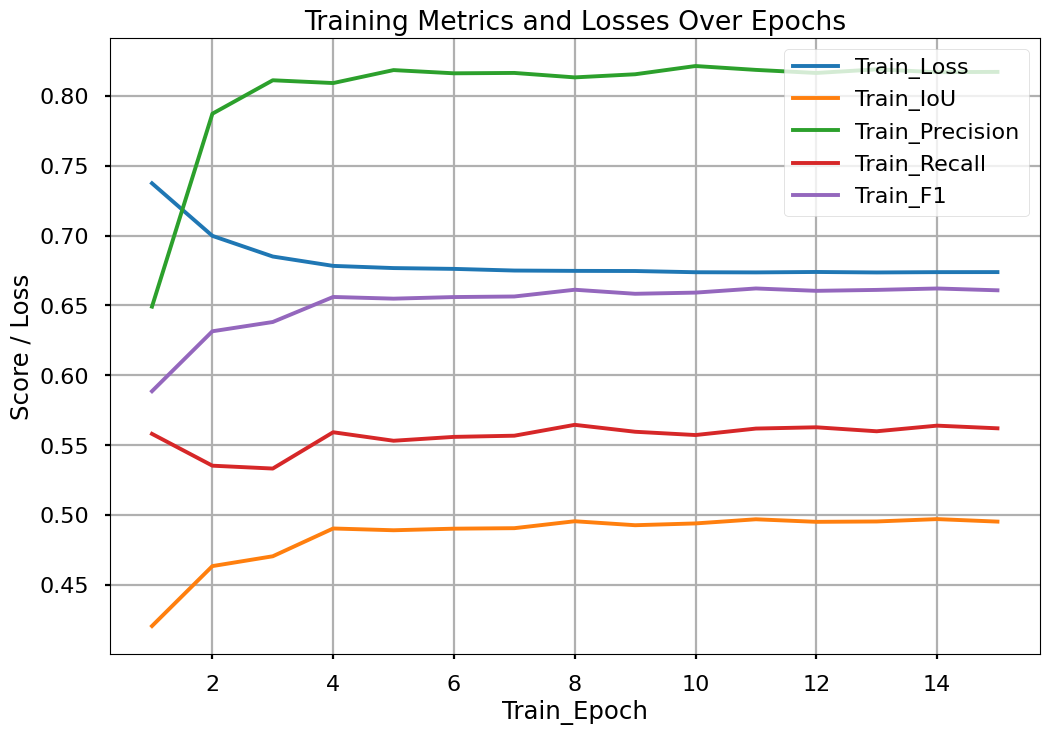

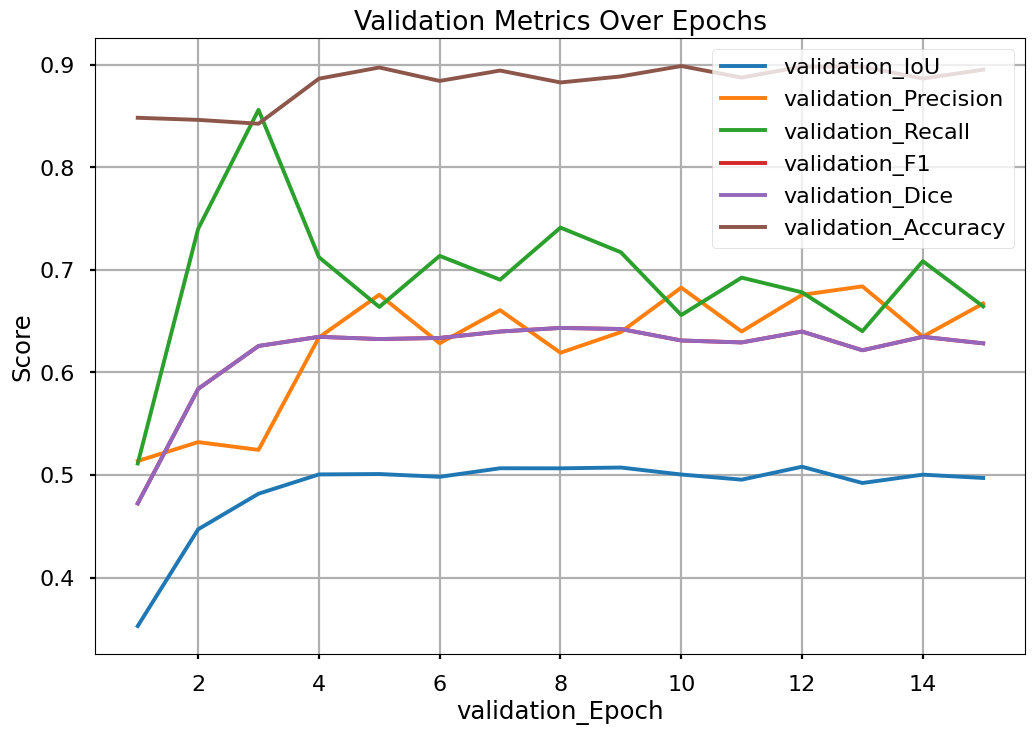

In [12]:
from torch.optim.lr_scheduler import StepLR

def main():
    
    # data augumentation:
    train_transform = A.Compose(
    [
      A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
      A.Rotate(limit = 35,p=1.0),
      A.HorizontalFlip(p=0.1),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0,0.0,0.0],
          std = [1.0,1.0,1.0],
          max_pixel_value = 255.0
      ),
      ToTensorV2(),
    ],is_check_shapes = False
    )

    val_transform = A.Compose(
    [
     A.Resize(height = IMAGE_HEIGHT,width = IMAGE_WIDTH),
     A.Normalize(
      mean=[0.0,0.0,0.0],
      std = [1.0,1.0,1.0],
      max_pixel_value = 255.0
    ),
    ToTensorV2(),
    ],is_check_shapes = False
    )

    # model instance:
    model = UNet(n_channels=3,num_classes=1).to(DEVICE)

    # defining loss:
    loss_fn = nn.BCEWithLogitsLoss()

    #defining optimizer:
    optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

    # setting loaders:
    train_loader,val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        val_dir,
        val_mask_dir,
        BATCH_SIZE,
        train_transform,
        val_transform,
        train_val,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    # if LOAD_MODEL :
    #   load_checkpoint(torch.load("my_checkpoint.pth.tar"),model,optimizer=optimizer)

    # check_accuracy(val_loader,model,device = DEVICE)

    scaler = torch.cuda.amp.GradScaler()


    # Initialize lists to store metric values for each epoch for validation dataset
    iou_scores = []
    precision_scores = []
    recall_scores = []
    f1_val = []
    dice_scores = []
    accuracy_vals = []

    # Initialize lists to store metric values for each epoch for training dataset
    iou_train = []
    precision_train = []
    recall_train = []
    f1_train = []
    loss_train = []
    accuracy_train = []


    for epoch in range(NUM_EPOCHS):
        scheduler.step()
        train_fn(epoch,NUM_EPOCHS,train_loader,model,optimizer,loss_fn,scaler,iou_train,precision_train,recall_train,f1_train,loss_train,accuracy_train)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)
        
        # check_accuracy
        val_loss = 0.0
        
        check_accuracy(val_loader,model,accuracy_vals,dice_scores,iou_scores,precision_scores,recall_scores,f1_val,device = DEVICE)
#         if epoch==0:
#             best_val_loss=val_loss
#             counter = 0
#             patience = 3
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             counter = 0
#         else:
#             counter += 1
#             if counter >= patience:
#                 print("Early stopping triggered.")
#                 save_predictions_as_imgs(
#                 val_loader,model,folder=saved_folder,device = DEVICE
#                 )
#                 func(epoch,loss_train,iou_train,precision_train,recall_train,f1_train,iou_scores,precision_scores,recall_scores, f1_val,dice_scores, accuracy_vals)
#                 break
                
        # print some examples to the folder
        save_predictions_as_imgs(
            val_loader,model,folder = saved_folder,device = DEVICE
        )
    print("Training finished")

    # Plot metrics and losses
    # Plot for Training dataset
    func(NUM_EPOCHS,loss_train,iou_train,precision_train,recall_train,f1_train,iou_scores,precision_scores,recall_scores, f1_val,dice_scores, accuracy_vals)

if __name__ == "__main__":
  main()